### Problem Statement:
a) Fragment length frequency
We are given a file with each line indicating where a DNA fragment has mapped on the chromosome. Our goal is to count individual fragment lengths, and then normalize it by the total count of all fragment lengths. Once we have the normalized count, we will plot that using plotting packages in python. X-axis will be fragment length (unit - base pairs) and Y-axis-> Normalized frequencies. Fragment length can be simply calculated by subtracting 2nd column from the 3rd.

b) Rescaling
Often, we will receive two sets of data with different empirical distribution. The goal is to rescale one (query) to the other (reference). We are given a reference distribution (reference.hist) and a query bed file (query.bed.gz). We have to rescale (subsample the data) so that when we draw the normalized frequency, it should almost match the reference


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import random
import gzip  # gzip is a file format and compression method that reduces file size and sppeds up data transfer, especially for web content
import matplotlib.pyplot as plt
from collections import Counter
# First working on fragment lengths, counting their frequenxy and normalizing their counts
def import_bed_file(bed_path):
    fragment_lengths = []
    with gzip.open(bed_path, 'rt') as f:
        for line in f:
            # Ignore the bad lines - causing errors
            if line.startswith('#') or not line.strip():
                continue
            # cols = line.strip().split('')   -> not working because the lines are unevenly spaced
            cols = line.strip().split('\t')
            col1 = int(cols[1])  # starting position of DNA fragment
            col2 = int(cols[2])  # Ending position of a DNA fragment
            fragment_lengths.append(col2 - col1)  # Length of DNA fragment
    return fragment_lengths, Counter(fragment_lengths)  # returns the count of all UNIQUE DNA fragments in a dictionary format

In [4]:
# fragment_lengths, length_freq = import_bed_file('/content/drive/MyDrive/query.bed.gz')
fragment_lengths, length_freq = import_bed_file('./query.bed.gz')

In [ ]:
# print(f'Fragment Lengths : {fragment_lengths}')
# print(f'Freq of each length (unique) : {length_freq}')  --> quite dangerous lines

Buffered data was truncated after reaching the output size limit.

In [5]:
# fragment_lengths = [120, 120, 134, 120, .....]
# length_freq = {120:6, 134:4, .....}
# Now we have the counts corresponding to each unique DNA fragment length, let's normalize them
def Normalize(length_freq):
    # Why do we normalize?? to reduce the noise, to prevent overfitting in future modelling work, to bring the datapoints within a particular range
    sum_tot = sum(length_freq.values())
    # Dictionary keys will be same, but their values is just now divided by the total sum (total number of fragments - summing up all the count values in the dictionary)
    return {l: freq/sum_tot for l, freq in length_freq.items()}

In [6]:
normalized_freq = Normalize(length_freq)

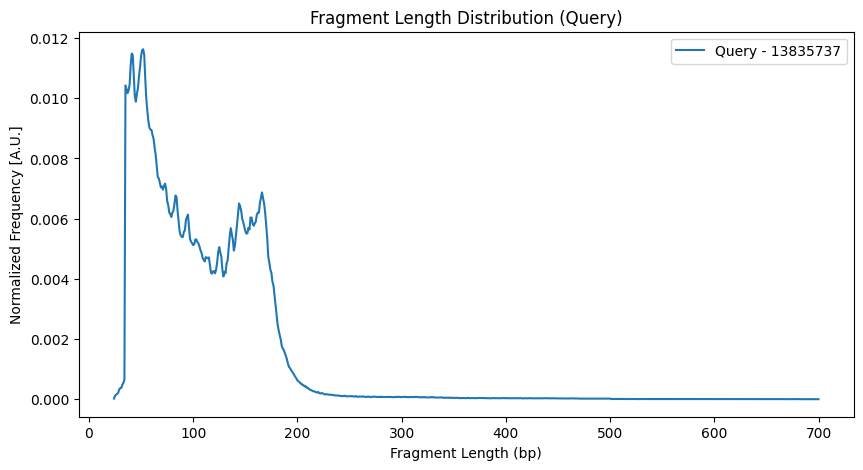

In [7]:
sorted_lengths = sorted(normalized_freq.keys())
sorted_freqs = [normalized_freq[l] for l in sorted_lengths]


plt.figure(figsize=(10,5))
plt.plot(sorted_lengths, sorted_freqs, label=f'Query - {sum(length_freq.values())}')
plt.xlabel("Fragment Length (bp)")
plt.ylabel("Normalized Frequency [A.U.]")
plt.title("Fragment Length Distribution (Query)")
plt.legend()
plt.show()

In [8]:
# For the second part of the problem - rescaling with reference given. It is similar to projecting a given dimension into some other dimension for easy comparison
def import_reference_histogram(ref_path):
    # dictionary with keys as lengths and values as their corresponding frequencies
    ref_freq = {}
    with open(ref_path) as f:
        for line in f:
            # For debugging purpose only
            # if line.startswith('#'):
            #     print("Bad line detected")
            #     count++
            #     continue
            if not line.strip():
                continue
            length, freq = map(float, line.strip().split('\t'))
            ref_freq[int(length)] = freq
    return ref_freq

In [9]:
# ref_freq_dict = import_reference_histogram('/content/drive/MyDrive/reference.hist')
ref_freq_dict = import_reference_histogram('./reference.hist')

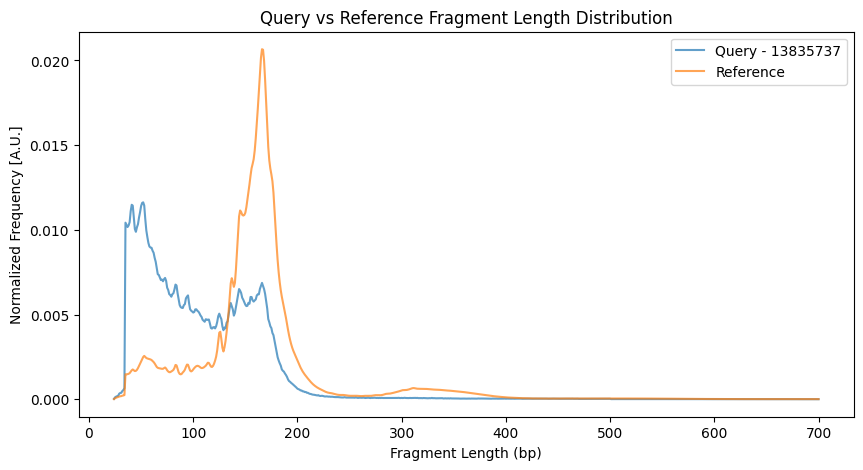

In [10]:
ref_lengths = sorted(ref_freq_dict.keys())
ref_freqs = [ref_freq_dict[l] for l in ref_lengths]

plt.figure(figsize=(10,5))
plt.plot(sorted_lengths, sorted_freqs, label=f'Query - {sum(length_freq.values())}', alpha=0.7)
plt.plot(ref_lengths, ref_freqs, label=f'Reference', alpha=0.7)
plt.xlabel("Fragment Length (bp)")
plt.ylabel("Normalized Frequency [A.U.]")
plt.title("Query vs Reference Fragment Length Distribution")
plt.legend()
plt.show()

In [11]:
frag_by_length = {}   # [120: [120, 120, 120, 120], 134: [134, 134], ......]
for l in fragment_lengths:
    frag_by_length.setdefault(l, []).append(l)

total_fragments = sum(length_freq.values())
target_total = int(total_fragments * 0.3)

rescaled_fragments = []

for l, ref_freq in ref_freq_dict.items():
    if l in frag_by_length:

        desired_count = int(ref_freq * target_total)

        current_pool = frag_by_length[l]
        sampled = random.sample(current_pool, min(len(current_pool), desired_count))
        rescaled_fragments.extend(sampled)

In [12]:
rescaled_counts = Counter(rescaled_fragments)
total_rescaled = sum(rescaled_counts.values())
rescaled_freq = {i: j / total_rescaled for i, j in rescaled_counts.items()}


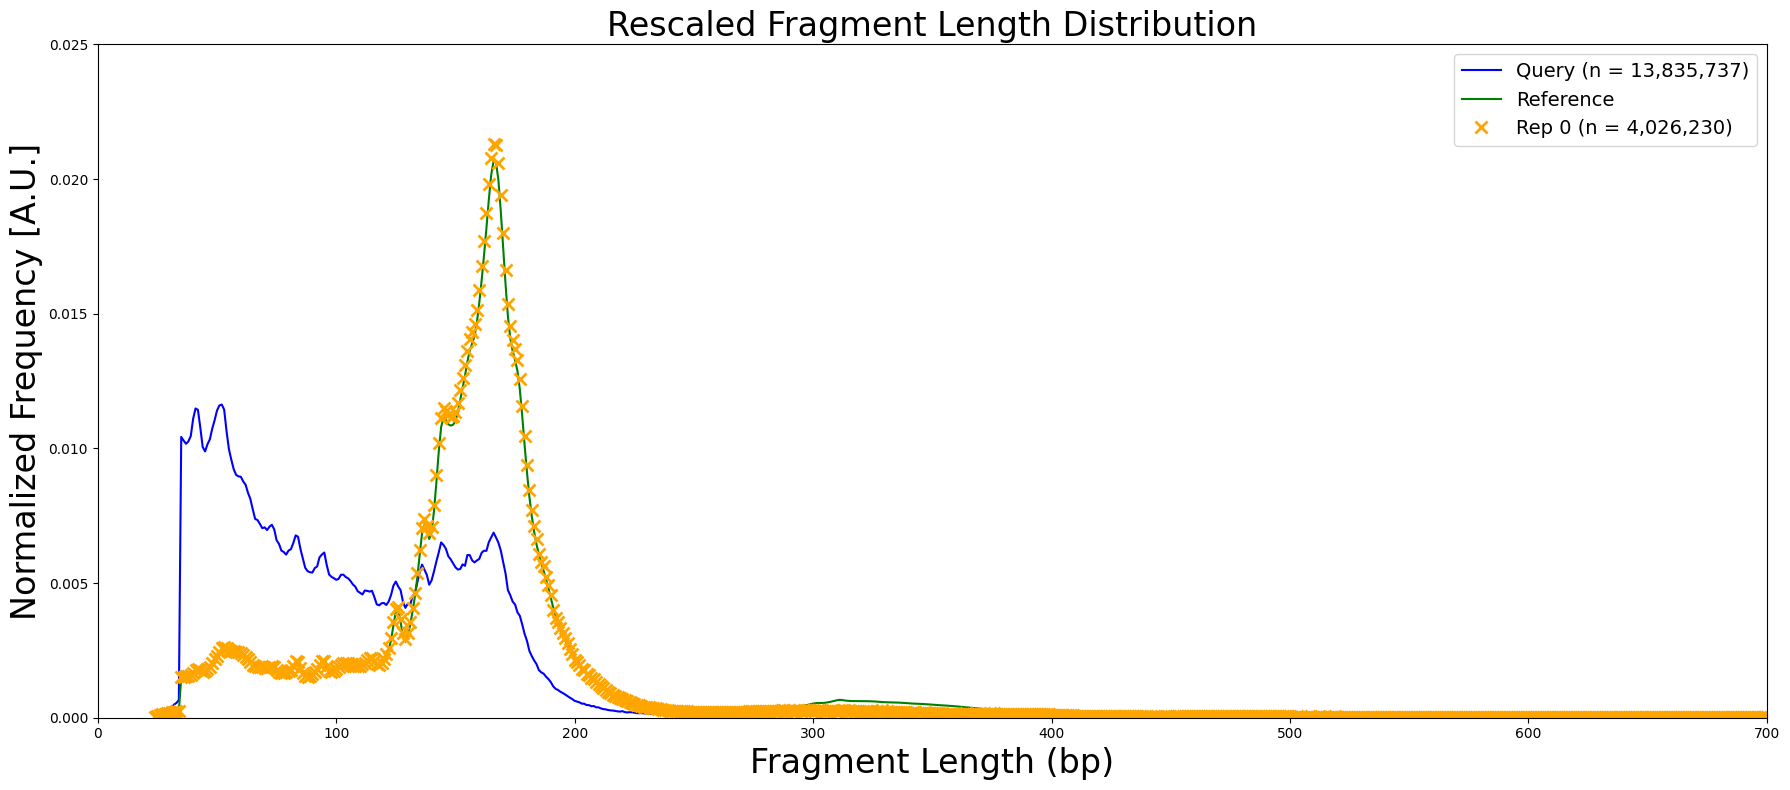

In [13]:
query_x, query_y = sorted_lengths, sorted_freqs
ref_x, ref_y = ref_lengths, ref_freqs
rescaled_x = sorted(rescaled_freq.keys())
rescaled_y = [rescaled_freq[k] for k in rescaled_x]

plt.figure(figsize=(18, 8))
plt.plot(query_x, query_y, label=f'Query (n = {total_fragments:,})', color='blue')
plt.plot(ref_x, ref_y, label='Reference', color='green')
plt.plot(rescaled_x, rescaled_y, 'x', label=f'Rep 0 (n = {total_rescaled:,})', color='orange', markersize=8, markeredgewidth=2)
plt.xlabel("Fragment Length (bp)", fontsize=24)
plt.ylabel("Normalized Frequency [A.U.]", fontsize=24)
plt.title("Rescaled Fragment Length Distribution", fontsize=24)
plt.xlim(0, 700)
plt.ylim(0, 0.025)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("./rescaled_prediction.png")
plt.show()

In [14]:



# # Function for rescaling of the file processed with above defined functions with the reference file
# def rescale(length_freq, ref_freq):
#     length_freq_normalized = Normalize(length_freq)
#     # determining the factors that each length in query dictionary(length_freq named here), should be multiplied with(if present in reference dataset as well)
#     # scaling_factors = {}
#     # for length in length_freq:
#     #     if length in ref_freq and length_freq_normalized[length]>0:
#     #         scaling_factors[length] = ref_freq[length] / length_freq_normalized[length]
#     #         # scaling_factors[length] = min(1.0, scaling_factors[length]) # to sure the scaling factor is not greater than 1
#     #         # Let's drop those columns which have scaling factors greater than 1, as we have to downscale the samples and not upscale them
#     #         if scaling_factors[length] > 1:
#     #             scaling_factors[length] = 0
#     #     else:
#     #         # for eliminating those lengths which are not present in the reference dictionary
#     #         scaling_factors = 0
#     # adjusted_counts = {}
#     # for length, freq in length_freq.items():
#     #     adjusted_counts[length] = int(round(freq * scaling_factors[length]))
#     keep_prob = {
#         l: min(1.0, ref_freq.get(l, 0) / length_freq_normalized[l])
#         for l in length_freq if length_freq_normalized[l] > 0
#     }
#     adjusted_counts = Counter()
#     for length, count in length_freq.items():
#         p = keep_prob.get(length, 0)
#         kept = sum(random.random() < p for _ in range(count))
#         if kept:
#             adjusted_counts[length] = kept
#     return adjusted_counts


# def plot_distributions(original, rescaled, reference):
#     # plt.figure(figsize=(8, 6))
#     plt.figure(figsize=(12, 6))
#     all_lengths = sorted(set(original.keys()) | set(reference.keys()))
#     orig_freq = Normalize(original)
#     rescaled_freq = Normalize(rescaled)
#     count_original = sum(original.values())
#     count_rescaled = sum(rescaled.values())
#     count_reference = sum([v for v in reference.values()])
#     # sum_original = sum(original.values())
#     plt.plot(all_lengths, [orig_freq.get(l,0) for l in all_lengths],
#              label=f'Original Query - {count_original}', linestyle='--', color='green')
#     plt.plot(all_lengths, [rescaled_freq.get(l,0) for l in all_lengths], color='red',marker='*', markersize=6,
#              label=f'Rescaled Query - {count_rescaled}', linewidth=0.8)
#     plt.plot(all_lengths, [reference.get(l,0) for l in all_lengths], color='blue',
#              label='Reference', alpha=0.8, linestyle='--', linewidth=2.5)

#     plt.xlabel('Fragment Length (bp)')
#     plt.ylabel('Normalized Frequency [A.U.]')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [15]:
# length_freq = import_bed_file('query.bed.gz')


In [16]:
# # Main function for execution
# if __name__ == "__main__":

#     normalized_length_freq = Normalize(length_freq)

#     adjusted_counts = rescale(length_freq, ref_freq)
#     plot_distributions(length_freq, adjusted_counts, ref_freq)